#**Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Installations**

In [ ]:
!pip install torchmetrics

#**Imports**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from torchmetrics import Accuracy
from tqdm import tqdm

import glob

#**Dataset**

# Load Dataset

In [ ]:
!cp '/content/drive/MyDrive/colab_projects/Recurrent Neural Network/UCI HAR Dataset.zip' /content

In [ ]:
!unzip '/content/UCI HAR Dataset.zip'

In [ ]:
def har_dataset(phase):
  x = []
  data_dir = f'/content/UCI HAR Dataset/{phase}/Inertial Signals/*'
  for file_dir in glob.glob(data_dir):
    x.append(np.loadtxt(file_dir))
  y = np.loadtxt(f'/content/UCI HAR Dataset/{phase}/y_{phase}.txt')
  x = torch.FloatTensor(x).permute(1, 2, 0)
  y = torch.LongTensor(y) - 1
  return x, y

In [ ]:
x_train, y_train = har_dataset('train')
x_test, y_test = har_dataset('test')

# Convert to Tensor

In [ ]:
train_set = TensorDataset(x_train, y_train)
test_set = TensorDataset(x_test, y_test)

In [ ]:
train_set, test_set = random_split(train_set, (5000, x_train.shape[0]-5000))

# DataLoader

In [ ]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(y.shape)

torch.Size([64, 128, 9])
torch.Size([64])


# **Visualize**

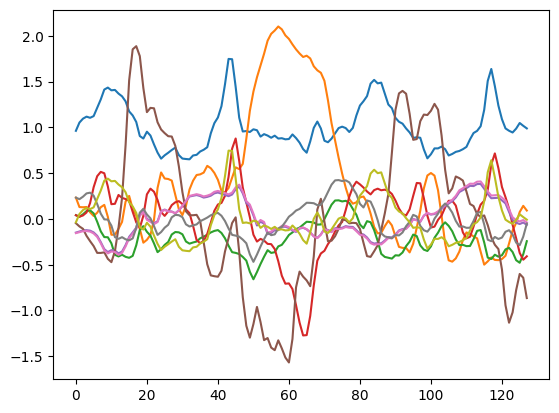

In [ ]:
plt.plot(x[0])

# **Model**

In [ ]:
model = nn.Sequential(nn.RNN(input_size=9, hidden_size=32, num_layers=4,
                             nonlinearity='tanh', bias=True, batch_first=True, dropout=0.,
                             bidirectional=True),
                      nn.Linear(64, 6))

#**RNN Model (from scratch)**

In [ ]:
class RNNModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, bidirectional, num_cls):
    super().__init__()
    self.rnn = nn.RNN(input_size=input_size,
                      hidden_size=hidden_size,
                      num_layers=num_layers,
                      bidirectional=bidirectional,
                      batch_first=True)
    self.fc = nn.LazyLinear(num_cls)

  def forward(self, x):
    outputs, _ = self.rnn(x)
    y = self.fc(outputs) #out: many
    y = y.mean(dim=1)
    return y

#**Device**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#**Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

#**Functions**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=6).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=6).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# **Setting Hyperparameters**

In [ ]:
model = RNNModel(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.8558, grad_fn=<NllLossBackward0>)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = RNNModel(9, 32, 1, False, 6).to(device)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:01<00:00, 19.25batch/s, accuracy=77, loss=0.547]


In [ ]:
num_epochs = 5
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001]:
  print(f'LR={lr}')
  model = RNNModel(9, 32, 4, False, 6).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 4: 100%|██████████| 79/79 [00:07<00:00, 10.59batch/s, accuracy=17.7, loss=2.28]



LR=0.5


Epoch 4: 100%|██████████| 79/79 [00:08<00:00,  8.92batch/s, accuracy=36, loss=1.4]



LR=0.2


Epoch 4: 100%|██████████| 79/79 [00:06<00:00, 12.50batch/s, accuracy=63.9, loss=0.826]



LR=0.1


Epoch 4: 100%|██████████| 79/79 [00:07<00:00, 10.27batch/s, accuracy=78.2, loss=0.548]



LR=0.01


Epoch 4: 100%|██████████| 79/79 [00:07<00:00, 10.28batch/s, accuracy=59.2, loss=1.01]



LR=0.001


Epoch 4: 100%|██████████| 79/79 [00:06<00:00, 12.74batch/s, accuracy=37.4, loss=1.4]

In [ ]:
num_epochs = 5

for lr in [0.08, 0.09, 0.1, 0.15, 0.2]:
  for wd in [1e-4, 1e-5, 0.]:
    model = RNNModel(9, 128, 1, True, 6).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)
    print()

LR=0.08, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:09<00:00,  7.92batch/s, accuracy=52.1, loss=1.04]



LR=0.08, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:09<00:00,  8.21batch/s, accuracy=51, loss=1.06]



LR=0.08, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:11<00:00,  7.05batch/s, accuracy=51.8, loss=1.03]



LR=0.09, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:09<00:00,  7.98batch/s, accuracy=52.9, loss=1.03]



LR=0.09, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:09<00:00,  8.01batch/s, accuracy=51.4, loss=1.04]



LR=0.09, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:09<00:00,  8.41batch/s, accuracy=52.8, loss=1.04]



LR=0.1, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:09<00:00,  8.44batch/s, accuracy=52, loss=1.03]



LR=0.1, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:09<00:00,  8.40batch/s, accuracy=51, loss=1.05]



LR=0.1, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:10<00:00,  7.22batch/s, accuracy=51.9, loss=1.03]



LR=0.15, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:08<00:00,  9.42batch/s, accuracy=53.3, loss=1.03]



LR=0.15, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:08<00:00,  9.55batch/s, accuracy=54.2, loss=1.02]



LR=0.15, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:08<00:00,  9.71batch/s, accuracy=53.4, loss=1.02]



LR=0.2, WD=0.0001


Epoch 4: 100%|██████████| 79/79 [00:08<00:00,  9.48batch/s, accuracy=53.8, loss=1.03]



LR=0.2, WD=1e-05


Epoch 4: 100%|██████████| 79/79 [00:08<00:00,  8.81batch/s, accuracy=54.6, loss=1.02]



LR=0.2, WD=0.0


Epoch 4: 100%|██████████| 79/79 [00:09<00:00,  8.59batch/s, accuracy=57.6, loss=0.981]

# **Training**

In [ ]:
model = RNNModel(9, 32, 4, False, 6).to(device)

In [ ]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 79/79 [00:09<00:00,  8.26batch/s, accuracy=40, loss=1.36]


Valid: Loss = 1.155, Acc = 0.5149



Epoch 1: 100%|██████████| 79/79 [00:07<00:00, 10.79batch/s, accuracy=64.8, loss=0.97]


Valid: Loss = 0.6553, Acc = 0.7768



Epoch 2: 100%|██████████| 79/79 [00:06<00:00, 11.81batch/s, accuracy=75.3, loss=0.684]


Valid: Loss = 0.614, Acc = 0.7768



Epoch 3: 100%|██████████| 79/79 [00:07<00:00, 10.81batch/s, accuracy=80.8, loss=0.507]


Valid: Loss = 0.4136, Acc = 0.8601



Epoch 4: 100%|██████████| 79/79 [00:08<00:00,  9.42batch/s, accuracy=86.9, loss=0.36]


Valid: Loss = 0.4001, Acc = 0.8648



Epoch 5: 100%|██████████| 79/79 [00:08<00:00,  9.85batch/s, accuracy=87.4, loss=0.355]


Valid: Loss = 0.4802, Acc = 0.827



Epoch 6: 100%|██████████| 79/79 [00:06<00:00, 12.44batch/s, accuracy=89.1, loss=0.323]


Valid: Loss = 0.4028, Acc = 0.8418



Epoch 7: 100%|██████████| 79/79 [00:08<00:00,  9.50batch/s, accuracy=89.1, loss=0.322]


Valid: Loss = 0.328, Acc = 0.8984



Epoch 8: 100%|██████████| 79/79 [00:06<00:00, 12.61batch/s, accuracy=90, loss=0.295]


Valid: Loss = 0.3766, Acc = 0.8605



Epoch 9: 100%|██████████| 79/79 [00:08<00:00,  9.74batch/s, accuracy=89.8, loss=0.293]


Valid: Loss = 0.247, Acc = 0.9184



# **Plot**

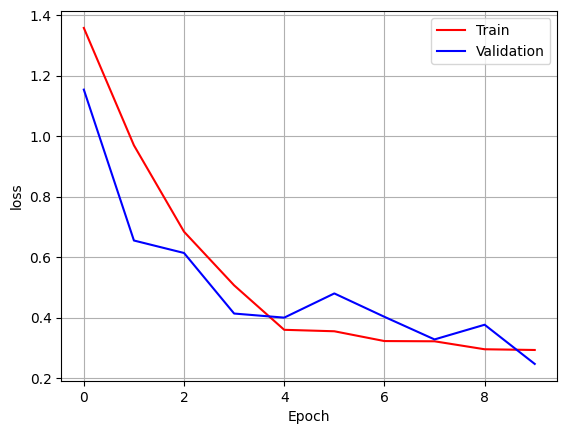

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

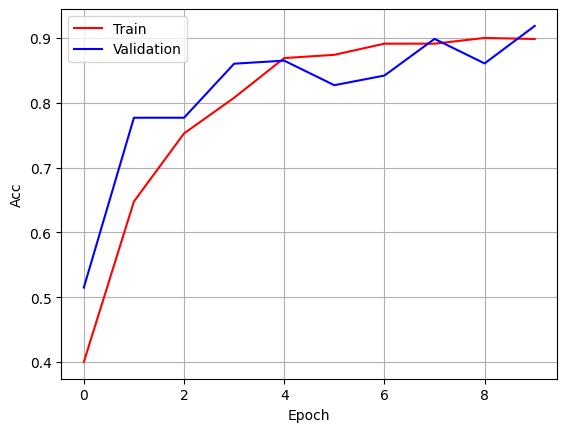

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()